In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# filtermasken generator
from math import ceil

xtrans="""gbggrg
rgrbgb
gbggrg
grggbg
bgbrgr
grggbg
"""
bayer = """gr
bg"""

def filtermask_from_str(w,h,pattern=bayer):
    d = {"r":[1,0,0],"g":[0,1,0],"b":[0,0,1]}
    a = np.array([[d[y] for y in x] for x in pattern.splitlines()]).astype("float32")
    (ph,pw,_) = a.shape
    return np.tile(a,(ceil(h/ph),ceil(w/pw),1))[0:h,0:w]

## Trainingsdaten vorbereiten
Bilder zunächst auf 50% runterskalieren um mögliche Mängel des Demosaic Verfahrens der Kamera zu verstecken. Dann wird das Bild nachträglich in eine Form gebracht die einem Bayer Sensor entspricht vor dem Demosaic Verfahren.

In [3]:
from pathlib import Path
from PIL import Image
import numpy as np
from itertools import product
from random import seed,shuffle

tile_size=32

training_dataset=[]

for p in Path("./training_images").iterdir():
    if p.is_file():
        # bilder laden und in numpy array umwandeln
        im = Image.open(p).convert('RGB')
        # bild runterskalieren um effekte vom ursprünglichen demosaic verfahren zu minimieren
        im = im.resize((im.width//2,im.height//2),Image.LANCZOS)
        
        im_a = np.asarray(im,'float32')
        im_a/=255
        im_b= np.asarray(im,'float32')
        im_b/=255
        
        # Bayer Pattern erzeugen
        im_a*=filtermask_from_str(im.width,im.height)
                
        #bild aufteilen 
        (h,w,_) = im_a.shape
        (h,w) = (h//tile_size,w//tile_size)
        
        for x,y in product(range(w),range(h)):
            tile_a = im_a[y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size,].copy()
            tile_b = im_b[y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size,].copy()
            training_dataset.append((tile_a,tile_b))

seed(42)
shuffle(training_dataset)

train_a,train_b = zip(*training_dataset)

train_a = np.array(train_a)
train_b = np.array(train_b)

### Mosaic zur Kontrolle anzeigen

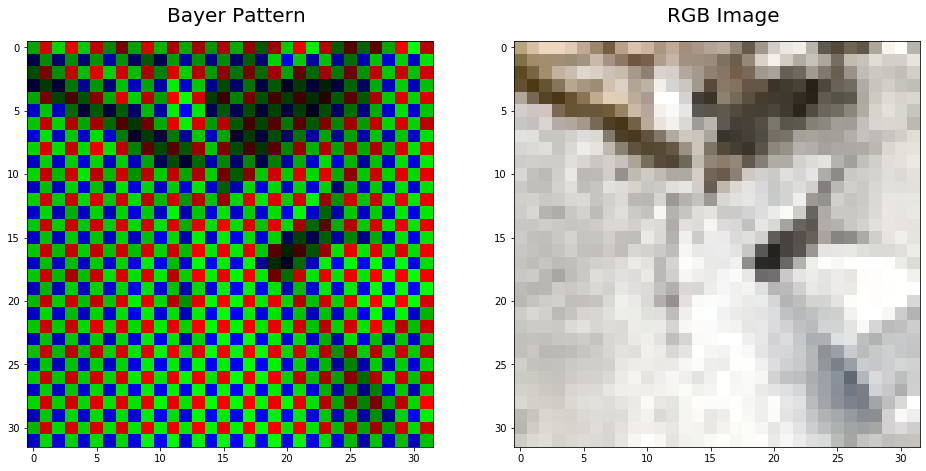

In [4]:
idx = 200

plt.figure(figsize=(16,16*2))
plt.subplot(1,2,1)
plt.imshow(train_a[idx],interpolation="nearest")
plt.text(16,-2,"Bayer Pattern",fontsize=20,horizontalalignment='center')
plt.subplot(1,2,2)
plt.imshow(train_b[idx],interpolation="nearest")
plt.text(16,-2,"RGB Image",fontsize=20,horizontalalignment='center')

plt.show()

## Modell erstellen

### Tensorflow soll sich nur den Speicher holen den es braucht anstatt sich alles unter den Nagel zu reißen
([Code aus Tensorflow Guide](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth))

In [5]:
import keras
from keras import backend as K

if K.backend() == 'tensorflow':
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


 Hatte PSNRLoss in einem anderem Projekt benutzt und war besser als die builtin metrics

In [6]:
def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

Vorerst nur ein sehr einfacher Autoencoder

In [7]:
from keras.layers import Conv2D,Conv2DTranspose,Input
from keras.models import Model


inp = Input(shape=(tile_size,tile_size,3))

conv1 = Conv2D(64,(3,3), activation='relu',strides=(2,2),padding='same')(inp)
deconv1 = Conv2DTranspose(64,(3,3),activation='relu', strides=(2,2), padding='same')(conv1)
out = Conv2DTranspose(3,(5,5),activation='linear',padding='same')(deconv1)

model = Model(inputs=inp, outputs=out)  
model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Adam(),
             metrics=[PSNRLoss])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 3)         4803      
Total params: 43,523
Trainable params: 43,523
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%time
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=5)
hist =  model.fit(train_a, train_b,
                    batch_size=32,
                    epochs=200,
                    shuffle=True,
                    validation_split=0.9,
                    callbacks=[early_stopping],
                    verbose=2)

Train on 3266 samples, validate on 29399 samples
Epoch 1/200
 - 4s - loss: 0.0270 - PSNRLoss: 18.0910 - val_loss: 0.0036 - val_PSNRLoss: 24.5313
Epoch 2/200
 - 3s - loss: 0.0024 - PSNRLoss: 26.4913 - val_loss: 0.0016 - val_PSNRLoss: 28.0406
Epoch 3/200
 - 3s - loss: 0.0013 - PSNRLoss: 29.0502 - val_loss: 9.5019e-04 - val_PSNRLoss: 30.3050
Epoch 4/200
 - 3s - loss: 7.8696e-04 - PSNRLoss: 31.2031 - val_loss: 6.4151e-04 - val_PSNRLoss: 32.0222
Epoch 5/200
 - 3s - loss: 6.0551e-04 - PSNRLoss: 32.2789 - val_loss: 5.2856e-04 - val_PSNRLoss: 32.8655
Epoch 6/200
 - 3s - loss: 4.7654e-04 - PSNRLoss: 33.3535 - val_loss: 4.3887e-04 - val_PSNRLoss: 33.6833
Epoch 7/200
 - 3s - loss: 4.2228e-04 - PSNRLoss: 33.9293 - val_loss: 3.6525e-04 - val_PSNRLoss: 34.5074
Epoch 8/200
 - 3s - loss: 3.6317e-04 - PSNRLoss: 34.4979 - val_loss: 3.2625e-04 - val_PSNRLoss: 35.0098
Epoch 9/200
 - 3s - loss: 3.3493e-04 - PSNRLoss: 34.9599 - val_loss: 3.1220e-04 - val_PSNRLoss: 35.1985
Epoch 10/200
 - 3s - loss: 3.2060e-

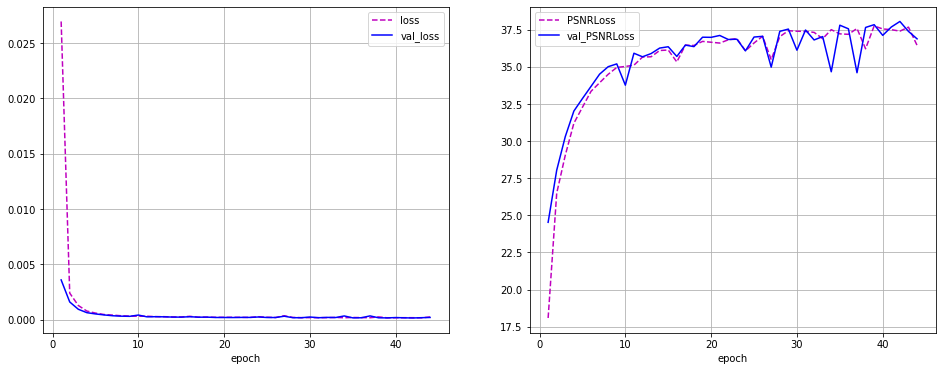

maximum PSNRLoss: 37.7553
minimum loss: 0.000177


In [9]:
import helper
helper.plot_model(hist,size=(16,6))

x = max(hist.history['PSNRLoss'])
print(f"maximum PSNRLoss: {x:.4f}")
x = min(hist.history['loss'])
print(f"minimum loss: {x:f}")

## Testlauf
(ist natürlich verfälscht da hier ein bild aus dem trainingsdatensatz verwendet wird)

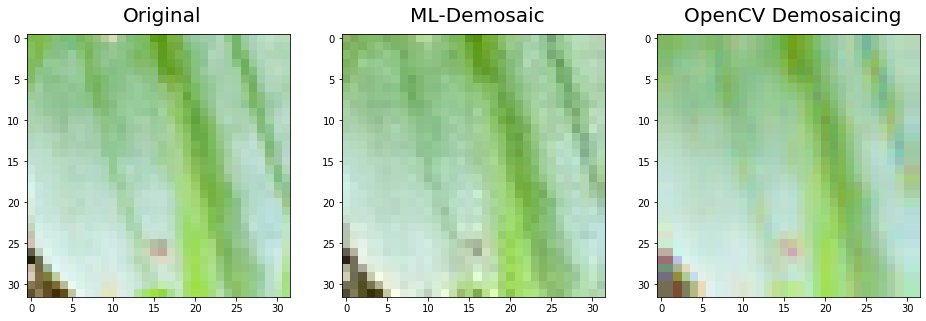

In [10]:
i = 12

plt.figure(figsize=(16,16*3))

#original bild anzeigen
plt.subplot(1,3,1)
plt.imshow(train_b[i],interpolation="nearest")
plt.text(16,-2,"Original",fontsize=20,horizontalalignment='center')

#demosicing durch den autoencoder
plt.subplot(1,3,2)
decoded = model.predict(train_a[i:i+1])
decoded = np.clip(decoded,0,1)
plt.imshow(decoded[0])
plt.text(16,-2,"ML-Demosaic",fontsize=20,horizontalalignment='center')

#opencv demosaicing algorithmus zum vergleich (irgendwas stimmt hier noch nicht)
plt.subplot(1,3,3)
import cv2
(h,w,_) = train_a[i].shape
# rgb bayer bild in graustufen umwandeln
a = np.zeros((h,w))
for x in range(h):
    for y in range(w):
        a[x,y] = sum(train_a[i][x,y]) # summe der 3 kanäle nehmen da 2 kanäle immer 0 sind
a = (a * 255).astype("uint8")
b = cv2.cvtColor(a, cv2.COLOR_BAYER_GB2RGB)
plt.imshow(b,interpolation="nearest")
plt.text(16,-2,"OpenCV Demosaicing",fontsize=20,horizontalalignment='center')

plt.show()